In [11]:
import os
import ipyparallel as ipp

rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()

got unknown result: b5d2bfc9-bbfe25668d2a59d708c329d6
got unknown result: a33b6adb-76eee1e01c248e05f6164659


In [12]:
print pid_map

{0: 184728, 1: 184726, 2: 184729, 3: 184727}


In [100]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output, update_display

In [89]:
%%bash
pip install filelock

In [90]:
%mkdir -p data

In [91]:
%%bash
cat > pi_calc.py << EOF
"""
Calculation of Pi using a Monte Carlo method.
"""

from math import hypot
from random import random
from time import time
import sys
import filelock

# A range is used in this function for python3. If you are using python2, a
# xrange might be more efficient.
def test(tries):
    return sum(hypot(random(), random()) < 1 for _ in range(tries))


# Calculates pi with a Monte-Carlo method. This function calls the function
# test "n" times with an argument of "t".
def calcPi(n, t):
    bt = time()
    expr = map(test, [t] * n)
    piValue = 4. * sum(expr) / float(n * t)
    totalTime = time() - bt
    print("pi = " + str(piValue))
    print("total time: " + str(totalTime))
    return (piValue, totalTime)

if __name__ == "__main__":
    dataPi, totalTime = calcPi(3000, 50000)
    with filelock.FileLock("calcPi.lock") as lock:
        with open("data/time_per_core.dat", "a") as f:
            # 1 core per run, totaltime
            f.write("%d %f\n" % (1, totalTime))
EOF

In [92]:
%cat pi_calc.py

"""
Calculation of Pi using a Monte Carlo method.
"""

from math import hypot
from random import random
from time import time
import sys
import filelock

# A range is used in this function for python3. If you are using python2, a
# xrange might be more efficient.
def test(tries):
    return sum(hypot(random(), random()) < 1 for _ in range(tries))


# Calculates pi with a Monte-Carlo method. This function calls the function
# test "n" times with an argument of "t".
def calcPi(n, t):
    bt = time()
    expr = map(test, [t] * n)
    piValue = 4. * sum(expr) / float(n * t)
    totalTime = time() - bt
    print("pi = " + str(piValue))
    print("total time: " + str(totalTime))
    return (piValue, totalTime)

if __name__ == "__main__":
    dataPi, totalTime = calcPi(3000, 50000)
    with filelock.FileLock("calcPi.lock") as lock:
        with open("data/time_per_core.dat", "a") as f:
            # 1 core per run, totaltime
            f.write("%d %f\n" % (1, totalTime))


In [25]:
%rm -f data/*.dat

In [93]:
rc[:]

<DirectView [0, 1, 2, 3]>

In [94]:
v = rc[:]

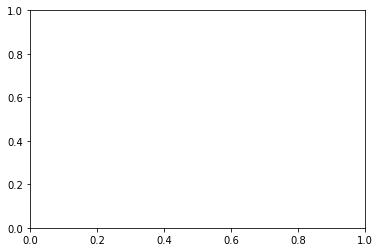

In [108]:
def get_data():
    with open("data/time_per_core.dat") as f:
        data = f.read()
    dataset = [(d.split()) for d in data.splitlines()]
    return dataset

    
fig, ax = plt.subplots()
def show_plot(dataset):
    clear_output(wait = True)
    x = [float(d[1]) for d in dataset]
    all_data = [x]
    labels = ['1 core',]

    # rectangular box plot
    bplot1 = ax.boxplot(all_data,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels)  # will be used to label x-ticks
    ax.yaxis.grid(True)
    ax.set_title('Pi computation (results for %d tries)'% len(x))
    ax.set_xlabel('Core used to compute')
    ax.set_ylabel('Compute time (s)')
    display(fig)

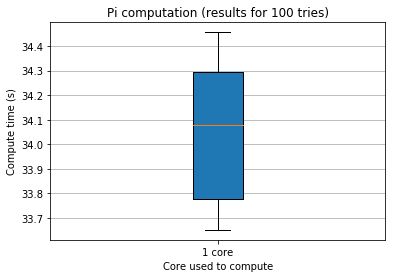

[stdout:0] 
pi = 3.14161938667
total time: 33.8917269707
[stdout:1] 
pi = 3.14150605333
total time: 34.4050741196
[stdout:2] 
pi = 3.14163144
total time: 34.2964138985
[stdout:3] 
pi = 3.14140533333
total time: 33.7559151649


In [109]:
for i in range(25):
    ar = v.run('pi_calc.py')
    ar.wait_for_output()
    dataset = get_data()
    show_plot(dataset)
    ar.display_outputs()

In [ ]:
%cat data/time_per_core.dat